In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd as autograd   

import torch

from scipy.interpolate import LinearNDInterpolator
device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print("Device 1: ",device1)
print("Device 2: ",device2)

Device 1:  cuda:2
Device 2:  cuda:3


In [2]:
filename = 'AFSD_Exp_300.pt'
data_filename = 'Exponential_300_2mms.mat'

R0 = 5 #mm 5.34
Rs = 19 #mm
mu_vis = 0.3 
mu = 0.3 #Friction Coefficient (not viscosity)
delta = 0.5
A = 6.41 #For slip factor
pi = np.pi
Omega = 300 #rpm
V = 2 #mm/s
F = 0.67 #mm
rho = 2700 * 1e-6 #g/mm3
k_B = 1.380649*1e-23 #J/K
R = 8.314 #J/(K.mol)
E_a = 205000 #J/mol #Q
alpha_sig = 52 #mm^2/N
# A = np.exp(27.78)
log_A = 27.78
n = 3.49
k = 0.167 #Thermal Conductivity #W/(mmK)
c_p = 0.897 #J/gK 
alpha_m = k/(rho*c_p)
T_a = 298.0


k_t = 0.0176 #W/(mmK)
c_p_t = 0.46 #J/gk
rho_t = 2700 * 1e-6 #g/mm3
alpha_t = k_t/(rho_t*c_p_t)

h_sides = 5*1e-6 #W/mm^2K
C_bot = 0.15*1e-6 #W/mm^2K^3

eeta = alpha_m/(alpha_m+alpha_t)

lb_xyz_uvw = np.array([-20.0,-20.0,-3.0])
ub_xyz_uvw = np.array([20.0,20.0,0.0])


lb_xyz = np.array([-50.0,-20.0,-3.0])
ub_xyz = np.array([50.0,20.0,0.0])



In [3]:
from Seq_Model_Parallel import coupled_PINN

layers1 = np.array([3,50,50,50,4]) #9 hidden layers
layers2 = np.array([3,50,50,50,1]) #9 hidden layers
# layers = np.array([3,50,50,50,5])
# layers = np.array([3,64,64,64,1])
model_PINN = coupled_PINN(layers1,layers2,device1,device2,lb_xyz,ub_xyz)

model_PINN.load_state_dict(torch.load(filename))

#Testing with FVM data
fvm_data = loadmat('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/Data/AFSD_Nikhil/' + data_filename)

u_fvm = fvm_data['u_star']
v_fvm = fvm_data['v_star']
w_fvm = fvm_data['w_star']

u_fvm = (u_fvm[0:-1,:,:] + u_fvm[1:,:,:])/2
v_fvm = (v_fvm[:,0:-1,:] + v_fvm[:,1:,:])/2
w_fvm = (w_fvm[:,:,0:-1] + w_fvm[:,:,1:])/2


Res_v_fvm = np.sqrt(np.square(u_fvm) + np.square(v_fvm) + np.square(w_fvm))
T_fvm = fvm_data['T']
sigma_e_fvm = fvm_data['effectivestress']
eps_e_fvm = fvm_data['effstrrate']
mu_vis_fvm = fvm_data['mu']

Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)


/home/smartlab/anaconda3/envs/raghav/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

# x_min = -20.0
# x_max = 20.0

# x = np.linspace(x_min,x_max,250)
x = np.linspace(x_min,x_max,251)
x = (x[0:-1] + x[1:]).reshape(-1,1)/2
y = np.linspace(y_min,y_max,101)
y = (y[0:-1] + y[1:]).reshape(-1,1)/2
z = np.linspace(z_min,z_max,13)
z = (z[0:-1] + z[1:]).reshape(-1,1)/2

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()

Res_v_PINN = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))

In [5]:
x = np.linspace(x_min,x_max,251)
x = (x[0:-1] + x[1:]).reshape(-1,1)/2
y = np.linspace(y_min,y_max,101)
y = (y[0:-1] + y[1:]).reshape(-1,1)/2
z = np.linspace(z_min,z_max,13)
z = (z[0:-1] + z[1:]).reshape(-1,1)/2

In [6]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)

T = T.cpu().detach().numpy()
eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()



In [7]:
def RMSE(a,b):
    return np.sqrt(np.mean(np.square(a-b)))

def RE(a_true,a):
    return np.linalg.norm((a_true-a).reshape(-1,),2)/np.linalg.norm(a_true.reshape(-1,),2)

def corr(a,b):
    return np.corrcoef(a.reshape(-1,),b.reshape(-1,))[0,1]


def correct_shape(a):
    a = a.reshape(12,250,100,order = 'C')
    return np.swapaxes(np.swapaxes(a,0,1),1,2)

def print_metrics(a,b,name):
    print(name+" :","RMSE ",RMSE(a.reshape(-1,),b.reshape(-1,)))
    print(name+" :","RE ", RE(a.reshape(-1,),b.reshape(-1,)))
    print(name+" :","Corr ", corr(a.reshape(-1,),b.reshape(-1,)))


T = correct_shape(T)
eps_e = correct_shape(eps_e)
sigma_e = correct_shape(sigma_e)
mu_vis = correct_shape(mu_vis)
Res_v_PINN = correct_shape(Res_v_PINN)
# mu_vis = correct_shape(mu_vis)

In [8]:
print_metrics(T_fvm,T,"T")
print_metrics(eps_e_fvm,eps_e,"Eps")
print_metrics(sigma_e_fvm,sigma_e,"Sigma")
print_metrics(Res_v_fvm,Res_v_PINN/1000,"Res V")
print_metrics(mu_vis_fvm,mu_vis,"Mu Vis")

T : RMSE  34.85281955542421
T : RE  0.06445561501593847
T : Corr  0.9635217407268891
Eps : RMSE  10.079967584182814
Eps : RE  1.739116493679106
Eps : Corr  0.9086131428597581
Sigma : RMSE  85860637.08594744
Sigma : RE  0.9999999987329254
Sigma : Corr  0.432858517208999
Res V : RMSE  0.0054156015709676255
Res V : RE  0.4243653309812224
Res V : Corr  0.8898616928045828
Mu Vis : RMSE  81857949655.89624
Mu Vis : RE  0.9999999999994473
Mu Vis : Corr  0.5178182373884422


In [9]:
# PLOTTING
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

x_min = -20.0
x_max = 20.0



x = np.linspace(x_min,x_max,200).reshape(-1,1)
# y = np.linspace(y_min,y_max,200).reshape(-1,1)
y = 0.0
z = np.linspace(z_min,z_max,50).reshape(-1,1)
# z = -0.125
X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()

In [68]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)

T = T.cpu().detach().numpy()
eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()

ValueError: cannot reshape array of size 10000 into shape (200,200)

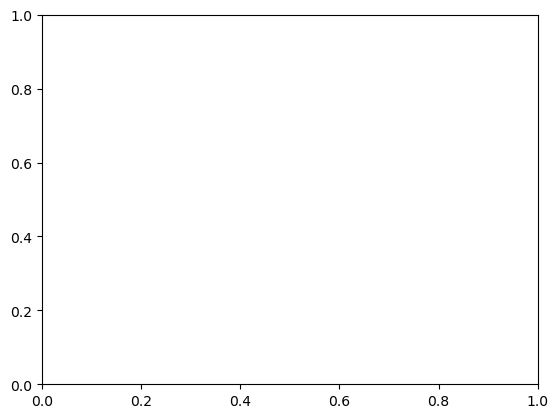

In [69]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((r_vel/1000).reshape(200,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_PureSlip.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$y$ (mm)')

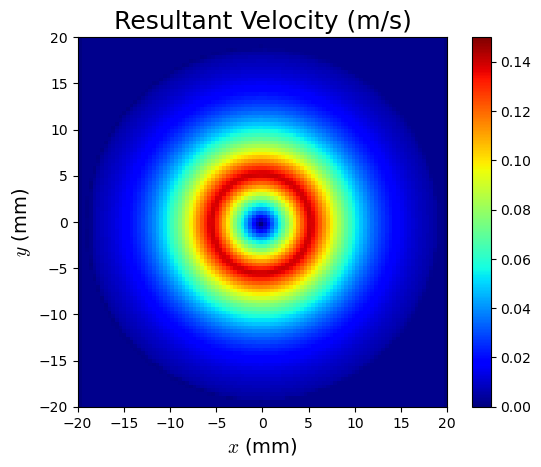

In [70]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(Res_v_fvm[75:175,:,-1],cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('FVM_Res_vel_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

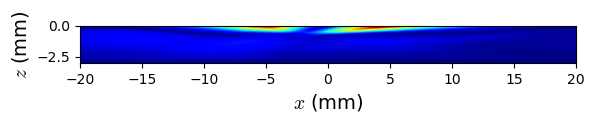

In [71]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((np.flip(r_vel)/1000).reshape(50,200),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_PureSlip_xz.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

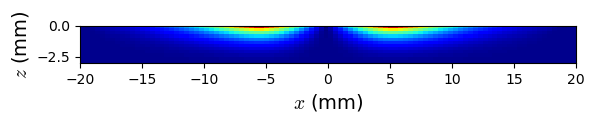

In [72]:
#FVM
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(Res_v_fvm[75:175,49,:])),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('FVM_Res_vel_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')

In [73]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)


eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()


ValueError: cannot reshape array of size 10000 into shape (200,200)

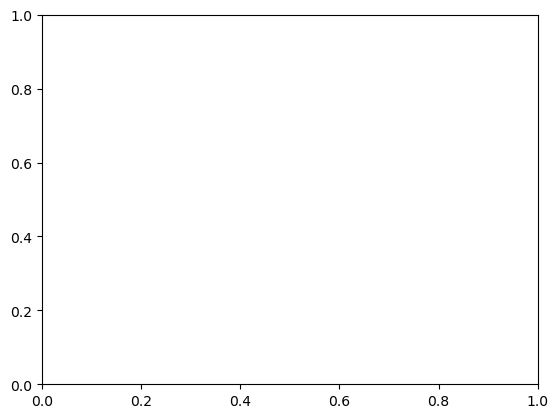

In [74]:
fig,ax = plt.subplots()
im = ax.imshow(T.cpu().detach().numpy().reshape(200,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 800,vmin = 300)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Temp_xy_Proposal.svg',format = 'svg',bbox_inches = 't

ValueError: cannot reshape array of size 10000 into shape (200,200)

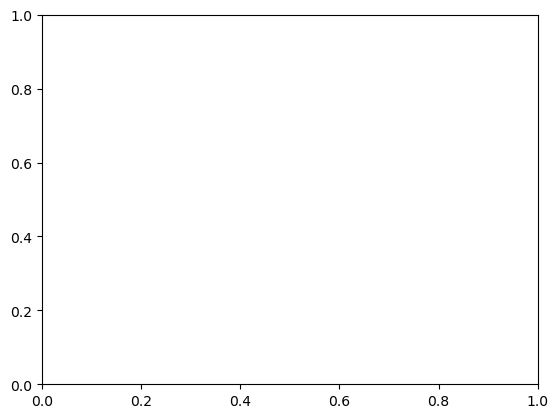

In [75]:
fig,ax = plt.subplots()
im = ax.imshow((eps_e/2).reshape(200,200),cmap = 'viridis',extent = [-20,20,-20,20],vmax = 80,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Eps_xy_QSR.svg',format = 'svg',bbox_inches = 'tight')

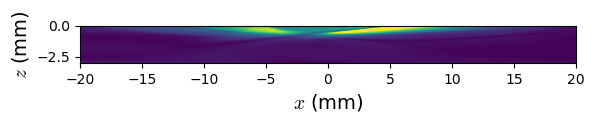

In [79]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip((eps_e/2).reshape(50,200)),cmap = 'viridis',extent = [-20,20,-3,0],vmax = 80,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('Eps_xz_QSR.svg',format = 'svg',bbox_inches = 'tight')

In [ ]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(eps_e.cpu().detach().numpy().reshape(50,200)),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)

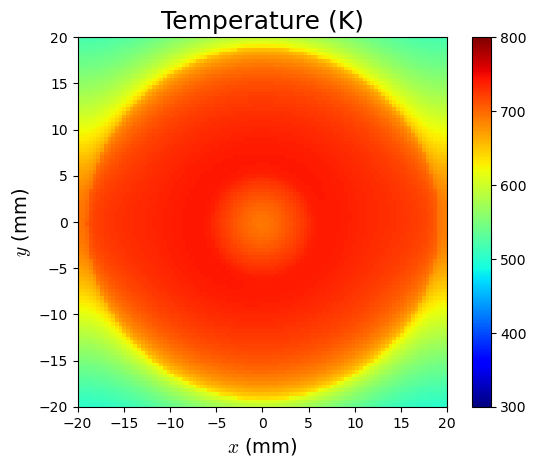

In [33]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(T_fvm[75:175,:,-1],cmap = 'jet',extent = [-20,20,-20,20],vmax = 800,vmin = 300)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_T_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

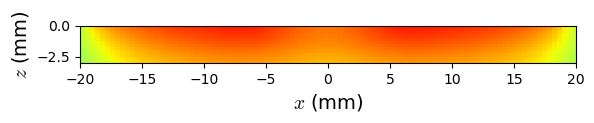

In [29]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(T_fvm[75:175,49,:])),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_T_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')

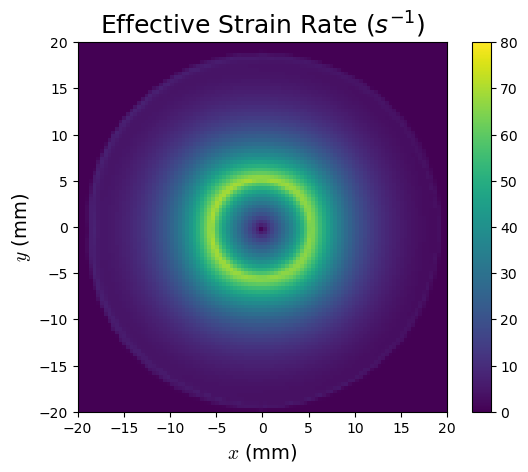

In [77]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(eps_e_fvm[75:175,:,-1],cmap = 'viridis',extent = [-20,20,-20,20],vmax = 80,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_eps_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

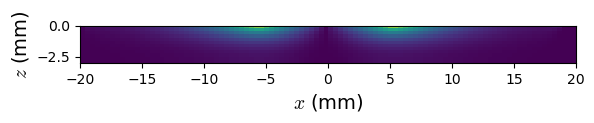

In [78]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(eps_e_fvm[75:175,49,:])),cmap = 'viridis',extent = [-20,20,-3,0],vmax = 80,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_eps_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')